identify characteristics of pitchers that lead to their success in specific roles, such as a traditional “starting pitcher”, a traditional “relief pitcher”, or any other pitching roles that you establish within your own analysis. Pick 2-3 to switch roles

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
%matplotlib inline
from sklearn import datasets
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from numpy.random.mtrand import random_sample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [499]:
#Decision tree classifier:
def DTC(X, y, choice):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0) #Train/Test
  dtc = DecisionTreeClassifier(random_state=0, criterion = choice).fit(X_train, y_train) #criterion{“gini, entropy”, “log_loss”}
  y_train_pred = dtc.predict(X_train)
  y_test_pred = dtc.predict(X_test)

  cm = confusion_matrix(y_test, y_test_pred)
  sns.heatmap(cm, annot=True,fmt='d',cbar=False); #confusion matrix
  print(classification_report(y_test,y_test_pred))

  cols = X.columns
  cols_plot = np.array([])
  importances_plot = np.array([])
  print("Most important features:")
  c = len(cols)
  for i in range(c): #Print features with at least 3% feature importance score
    if(dtc.feature_importances_[i] >=0.03):
      print(cols[i], format(dtc.feature_importances_[i], ".1%"), sep = " - ")
      cols_plot = np.append(cols_plot, cols[i])
      importances_plot = np.append(importances_plot, dtc.feature_importances_[i] * 100)

  #Feature importance bar plot:
  plt.figure(figsize=(20,6))
  plt.bar(cols_plot, importances_plot, color ='blue', width = 0.6)
  plt.ylabel('Feature Importance')
  plt.xlabel('Important Features');

In [495]:
#Random Forest Classifier:
def RFC(X, y, depth):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0) #Train/Test
  rfc = RandomForestClassifier(max_depth = depth, random_state = 0)
  rfc.fit(X_train, y_train)
  y_train_pred = rfc.predict(X_train)
  y_test_pred = rfc.predict(X_test)

  cm = confusion_matrix(y_test, y_test_pred)
  sns.heatmap(cm, annot=True,fmt='d',cbar=False); #confusion matrix
  print(classification_report(y_test,y_test_pred))

  cols = X.columns
  c = len(cols)
  cols_plot = np.array([])
  importances_plot = np.array([])
  print("Most important features:")
  for i in range(c): #Print features with at least 3% feature importance score
    if(rfc.feature_importances_[i] >=0.03):
      cols_plot = np.append(cols_plot, cols[i])
      print(cols[i], format(rfc.feature_importances_[i], ".1%"), sep = " - ")
      importances_plot = np.append(importances_plot, rfc.feature_importances_[i] * 100)

  #Feature importance bar plot:
  plt.figure(figsize=(20,6))
  plt.bar(cols_plot, importances_plot, color ='blue', width = 0.6)
  plt.ylabel('Feature Importance')
  plt.xlabel('Important Features');

In [602]:
#AdaBoost Classifier:
def ADA(X, y, n, rate, predict_df, alg):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0) #Train/Test
  ada = AdaBoostClassifier(random_state=0, learning_rate = rate, algorithm = alg, n_estimators= n) #n = 50 is default, algorithm="SAMME.R" or "SAMME", learning_rate = 1
  ada.fit(X_train, y_train)
  y_train_pred = ada.predict(X_train)
  y_test_pred = ada.predict(X_test)

  prediction = ada.predict(predict_df)
  print("In this role, he would have been", prediction, sep = " ")
  print()

  cm = confusion_matrix(y_test, y_test_pred)
  sns.heatmap(cm, annot=True,fmt='d',cbar=False); #confusion matrix
  print(classification_report(y_test,y_test_pred))

  cols = X.columns
  c = len(cols)
  cols_plot = np.array([])
  importances_plot = np.array([])
  print("Most important features:")
  for i in range(c): #Print features with at least 3% feature importance score
    if(ada.feature_importances_[i] >=0.03):
      print(cols[i], format(ada.feature_importances_[i], ".1%"), sep = " - ")
      cols_plot = np.append(cols_plot, cols[i])
      importances_plot = np.append(importances_plot, ada.feature_importances_[i] * 100)

  #Feature importance bar plot:
  plt.figure(figsize=(20,6))
  plt.bar(cols_plot, importances_plot, color ='blue', width = 0.6)
  plt.ylabel('Feature Importance')
  plt.xlabel('Important Features');

# **Savant**

In [670]:
df_savant = pd.read_csv('savant_pitch_level.csv')

threshold = len(df_savant)*.95
df_savant.dropna(thresh = threshold, axis = 1, inplace = True) #Drop columns with more than 5% of its values being NA
df_savant.sort_values("pitcher", inplace = True)
df_savant.fillna(method="ffill", inplace = True) #Fill remaining columns with low number of NA
                                                  #with a value based on the previous row

In [671]:
#Recode values for classifiers:
df_savant['description'].replace(['ball', 'blocked_ball', "hit_by_pitch"], 'negative', inplace=True)
df_savant['description'].replace(['foul', 'called_strike', "swinging_strike", "bunt_foul_tip",
                                     "foul_bunt", "foul_tip", "missed_bunt", "swinging_strike_blocked",
                                     "unknown_strike"], 'positive', inplace=True)

#Drop neutral values:
df_savant.drop(df_savant[df_savant['description'] == 'neutral'].index, inplace = True)
df_savant["description"].replace(["hit_into_play", "pitchout"], "neutral", inplace = True) #unsure if hit into play was pos or neg
df_savant = df_savant.drop(df_savant[df_savant['description'] == 'neutral'].index) #drop neutral values

#Get potential inputs for Savant classifiers:
#Get rid of variables about result of pitch
df_savant.drop(columns = ["plate_x", "plate_z", "zone", "delta_run_exp", "delta_home_win_exp",
                                    "effective_speed", "post_away_score",
                                    "post_home_score", "post_bat_score", "post_fld_score",
                                    "sp_indicator", "rp_indicator", "game_pk"],
                                    inplace = True)

In [672]:
#Split into RP vs SP:
df_savant_RP = df_savant[df_savant["role_key"] == "RP"]
df_savant_SP = df_savant[df_savant["role_key"] == "SP"]

df_savant_SP_inputs = df_savant_SP.select_dtypes(exclude=['object']) #drop strings
df_savant_RP_inputs = df_savant_RP.select_dtypes(exclude=['object']) #drop strings

**SP**

In [673]:
#Scale SP inputs:
scaler = StandardScaler()
Savant_SP_inputs_scaled = pd.DataFrame(scaler.fit_transform(df_savant_SP_inputs), columns = df_savant_SP_inputs.columns)

#Set inputs and target:
X = Savant_SP_inputs_scaled
y = df_savant_SP["description"]

**Predict if result of pitch is positive or negative based on pitch/game info.:**

              precision    recall  f1-score   support

    negative       0.69      0.68      0.68    131371
    positive       0.76      0.76      0.76    171431

    accuracy                           0.73    302802
   macro avg       0.72      0.72      0.72    302802
weighted avg       0.73      0.73      0.73    302802

Most important features:
release_pos_x - 6.4%
release_pos_z - 6.0%
vx0 - 8.5%
vy0 - 3.2%
vz0 - 11.5%
ax - 3.2%
az - 5.3%
sz_top - 6.1%
sz_bot - 7.7%


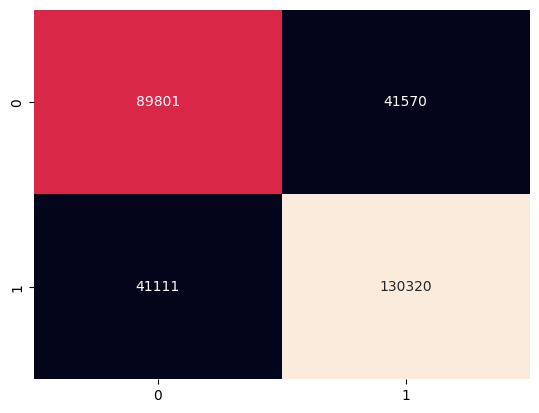

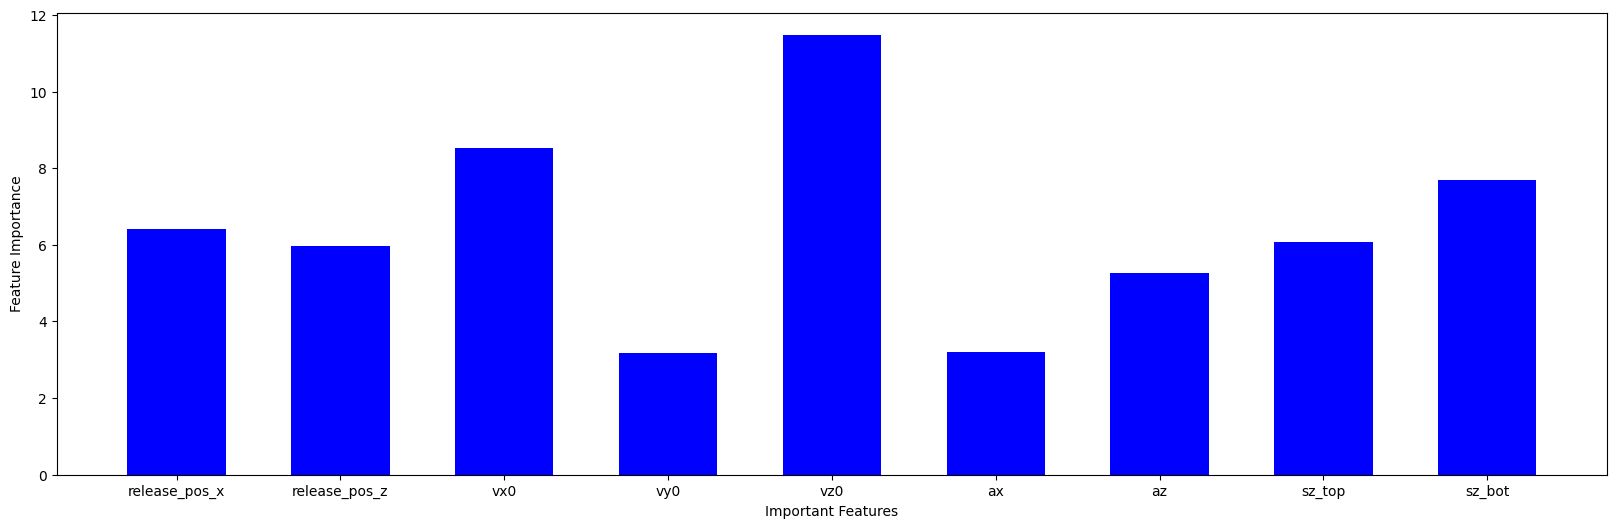

In [674]:
DTC(X, y, "gini") #criterion{“gini, entropy”, “log_loss”} #73% accuracy

              precision    recall  f1-score   support

    negative       0.84      0.20      0.32    131371
    positive       0.61      0.97      0.75    171431

    accuracy                           0.63    302802
   macro avg       0.72      0.58      0.53    302802
weighted avg       0.71      0.63      0.56    302802

Most important features:
balls - 4.5%
game_year - 3.9%
vx0 - 16.0%
vz0 - 33.9%
az - 3.9%
sz_top - 11.8%
sz_bot - 11.1%


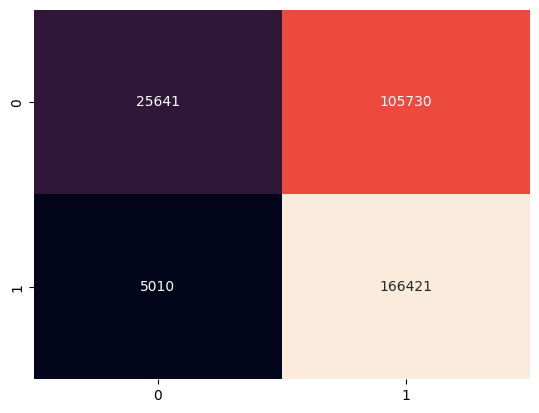

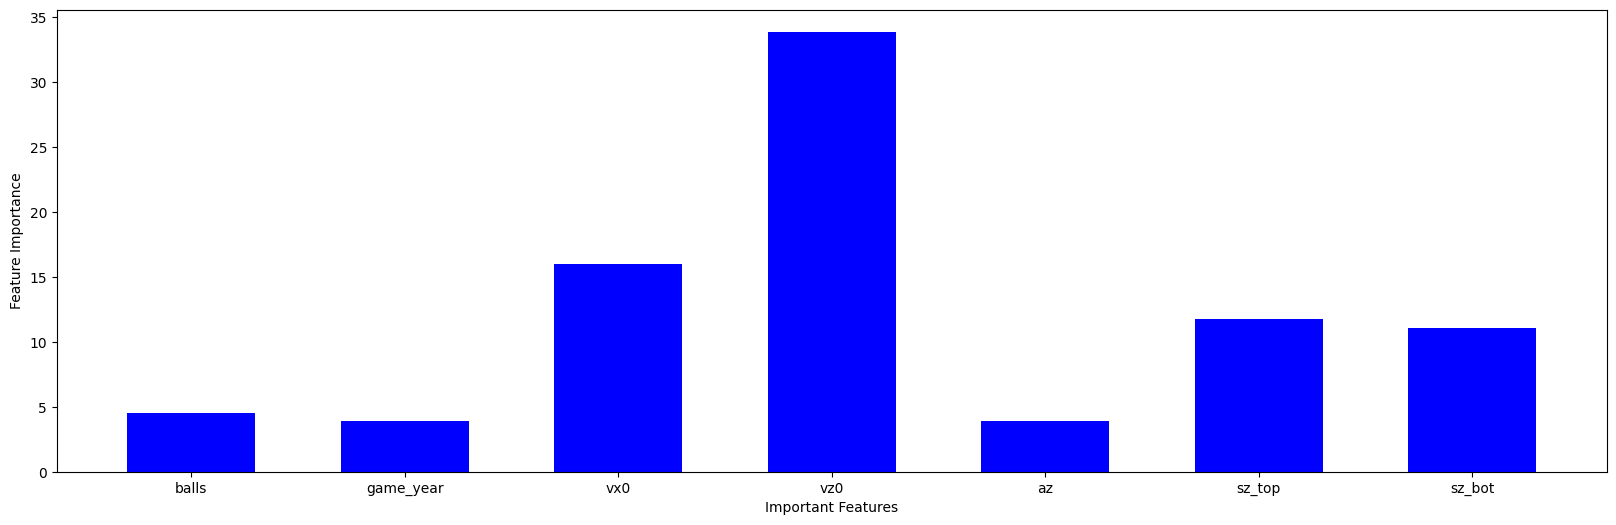

In [675]:
RFC(X, y, 5) #63% accuracy

In [676]:
predict_df = Savant_SP_inputs_scaled.iloc[0, :]
predict_df = pd.DataFrame(predict_df)
predict_df = predict_df.transpose()

In this role, he would have been ['positive']

              precision    recall  f1-score   support

    negative       0.64      0.42      0.51    131371
    positive       0.65      0.82      0.73    171431

    accuracy                           0.65    302802
   macro avg       0.65      0.62      0.62    302802
weighted avg       0.65      0.65      0.63    302802

Most important features:
release_speed - 4.0%
release_pos_x - 4.0%
balls - 4.0%
strikes - 4.0%
pfx_z - 4.0%
vx0 - 18.0%
vz0 - 20.0%
ax - 4.0%
az - 8.0%
sz_top - 12.0%
sz_bot - 12.0%


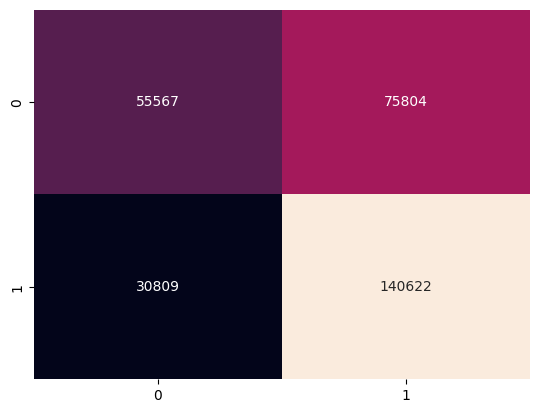

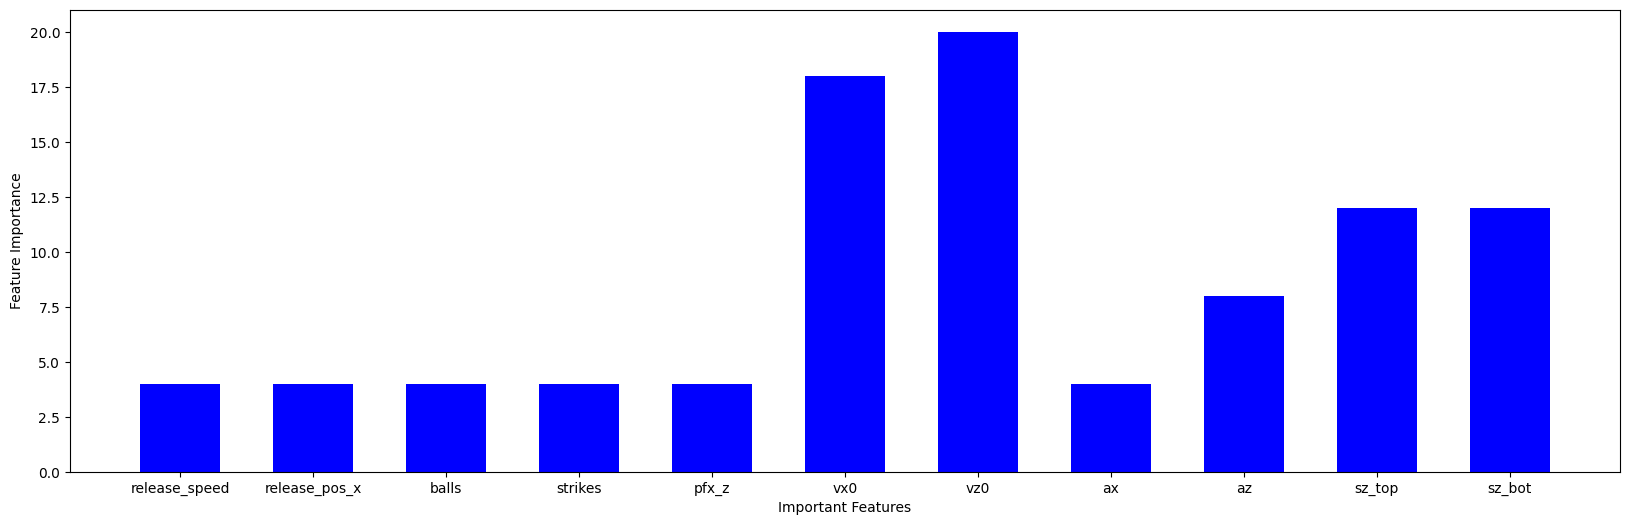

In [677]:
ADA(X, y, 50, 1, predict_df, "SAMME.R") #algorithm="SAMME.R" or "SAMME" #65% accurate, learning_rate = 1; #65% accuracy

**RP**

In [678]:
#Scale reliever inputs:
Savant_RP_inputs_scaled = pd.DataFrame(scaler.fit_transform(df_savant_RP_inputs), columns = df_savant_RP_inputs.columns)

#Set inputs and target:
X = Savant_RP_inputs_scaled
y = df_savant_RP["description"]

**Predict if result of pitch is positive or negative based on pitch/game info.:**

              precision    recall  f1-score   support

    negative       0.68      0.68      0.68     99028
    positive       0.75      0.75      0.75    127968

    accuracy                           0.72    226996
   macro avg       0.71      0.71      0.71    226996
weighted avg       0.72      0.72      0.72    226996

Most important features:
release_pos_x - 6.6%
release_pos_z - 6.0%
vx0 - 8.0%
vy0 - 3.3%
vz0 - 11.1%
az - 4.1%
sz_top - 6.0%
sz_bot - 8.6%


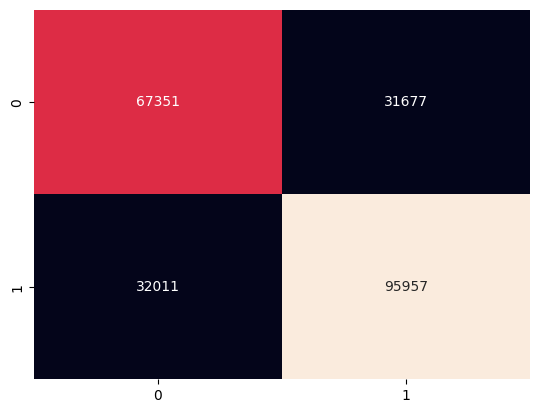

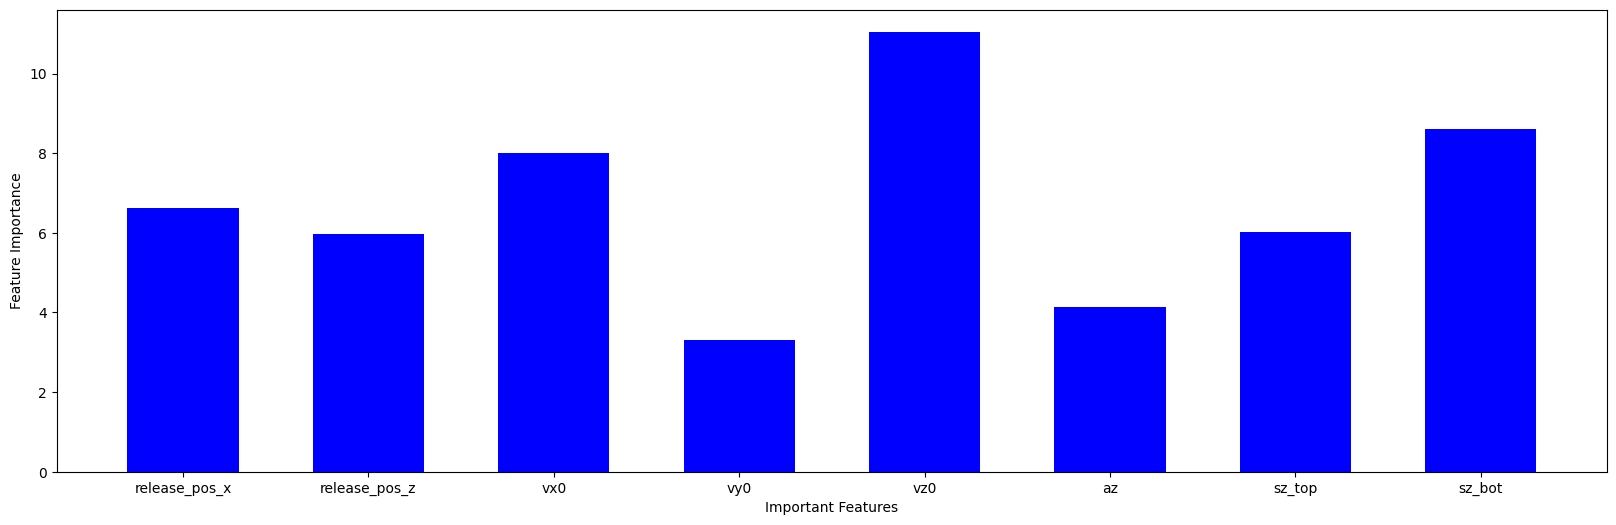

In [679]:
DTC(X, y, "gini") #criterion{“gini", "entropy”, “log_loss”}; 72% accuracy

              precision    recall  f1-score   support

    negative       0.83      0.19      0.31     99028
    positive       0.61      0.97      0.75    127968

    accuracy                           0.63    226996
   macro avg       0.72      0.58      0.53    226996
weighted avg       0.70      0.63      0.56    226996

Most important features:
balls - 3.7%
game_year - 4.9%
vx0 - 12.6%
vz0 - 32.1%
az - 3.4%
sz_top - 15.2%
sz_bot - 12.6%


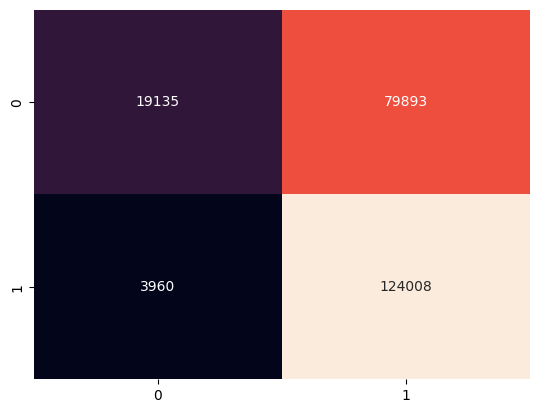

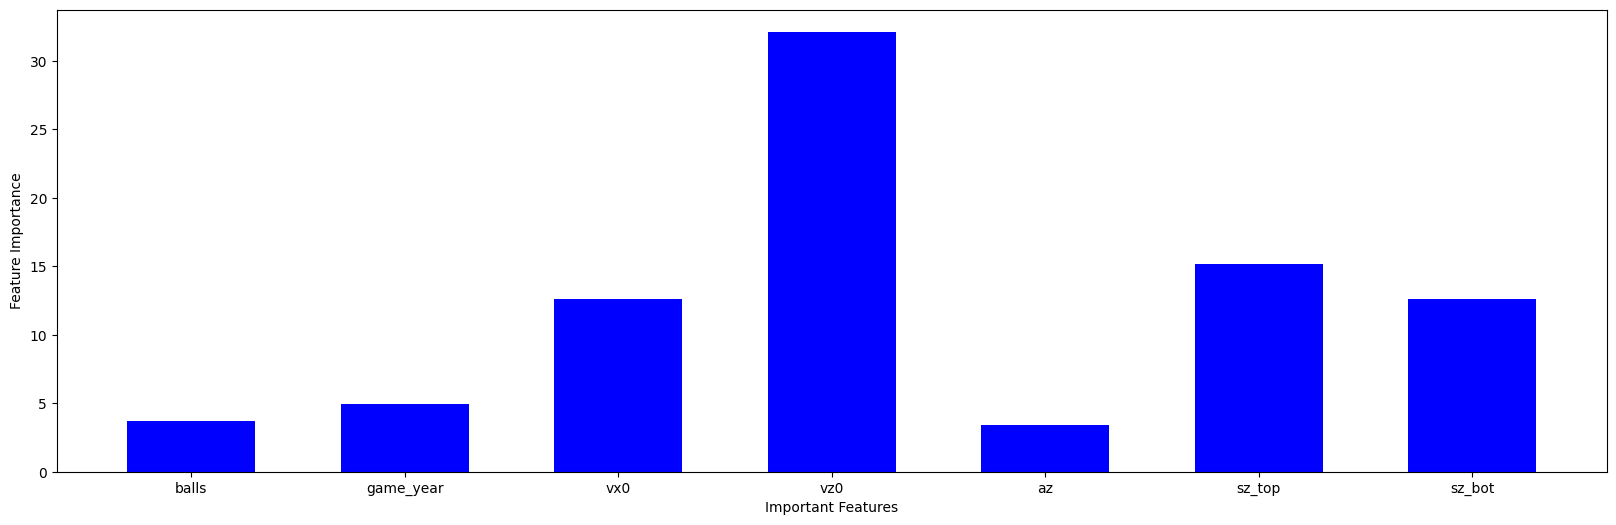

In [680]:
RFC(X, y, 5) #63% accuracy

In [681]:
predict_df = Savant_RP_inputs_scaled.iloc[0, :]
predict_df = pd.DataFrame(predict_df)
predict_df = predict_df.transpose()

In this role, he would have been ['positive']

              precision    recall  f1-score   support

    negative       0.69      0.13      0.22     99028
    positive       0.59      0.96      0.73    127968

    accuracy                           0.60    226996
   macro avg       0.64      0.54      0.47    226996
weighted avg       0.63      0.60      0.51    226996

Most important features:
vx0 - 98.0%


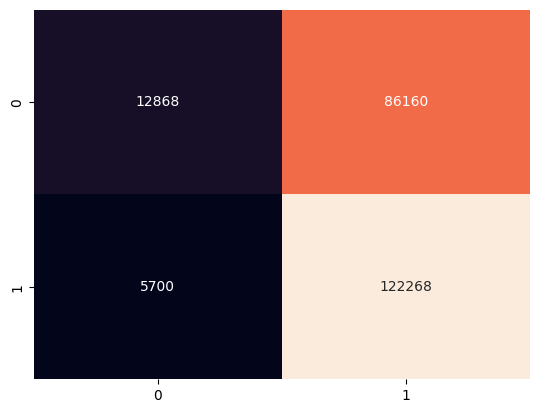

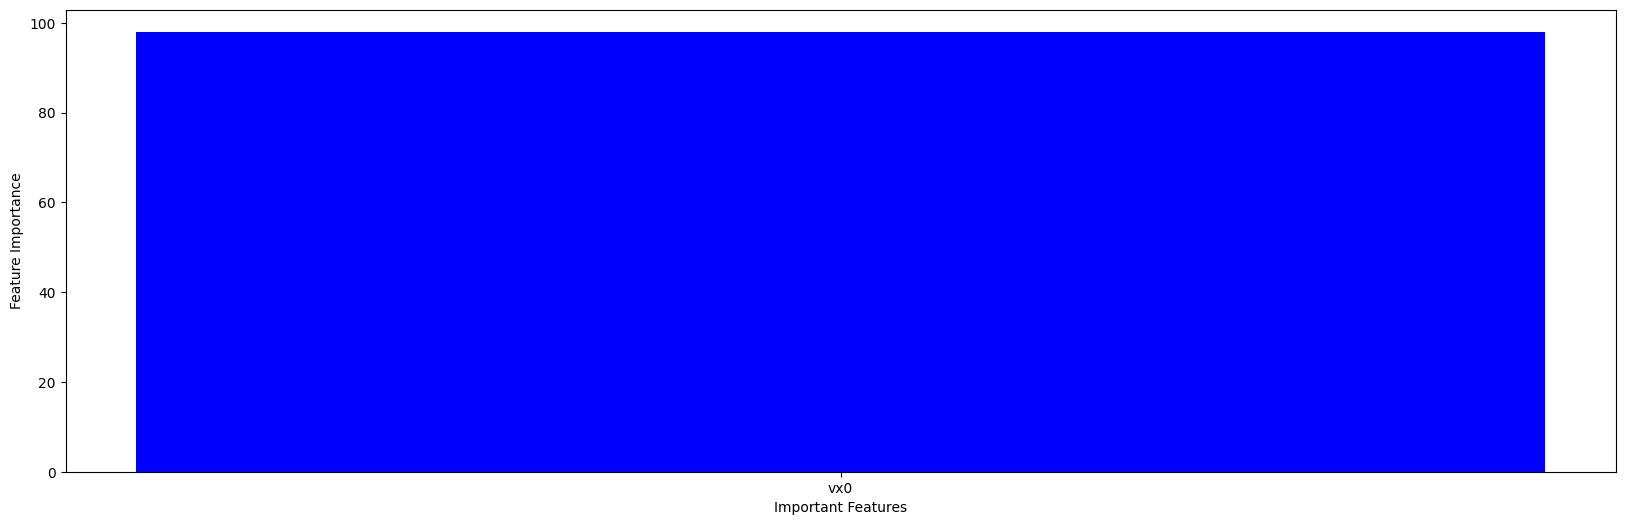

In [682]:
ADA(X, y, 50, 1, predict_df, "SAMME.R") #algorithm="SAMME.R" or "SAMME", learning_rate = 1; 60% accuracy

# **Fangraphs**

In [683]:
df = pd.read_csv('fangraphs_season_level.csv')
threshold = len(df)*.95
df_cleaned = df.dropna(thresh = threshold, axis = 1) #Drop columns with more than 5% of its values being NA
df_cleaned.sort_values("PlayerId", inplace = True)
df_cleaned.fillna(method="ffill", inplace = True) #Fill remaining columns with low number of NA
                                                  #with a value based on the previous row

<ipython-input-683-8acf526d63c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.sort_values("PlayerId", inplace = True)
<ipython-input-683-8acf526d63c4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.fillna(method="ffill", inplace = True) #Fill remaining columns with low number of NA


In [684]:
#Get data for Fangraphs Classifier Models:
#Recode to good/not good based on WAR:
df_notg_SP = df_cleaned[df_cleaned["Role"] == "SP"]
df_notg_SP.drop(df_notg_SP["WAR"][df_notg_SP["WAR"] >= 2.3].index, inplace = True)
df_notg_SP["WAR"][df_notg_SP["WAR"] < 2.3] = "not good"

df_good_SP = df_cleaned[df_cleaned["Role"] == "SP"]
df_good_SP.drop(df_good_SP["WAR"][df_good_SP["WAR"] < 2.3].index, inplace = True)
df_good_SP["WAR"][df_good_SP["WAR"] >= 2.3] = "good"

df_notg_RP = df_cleaned[df_cleaned["Role"] == "RP"]
df_notg_RP.drop(df_notg_RP["WAR"][df_notg_RP["WAR"]>=0.4].index, inplace = True)
df_notg_RP["WAR"][df_notg_RP["WAR"] < 0.4] = "not good"

df_good_RP = df_cleaned[df_cleaned["Role"] == "RP"]
df_good_RP.drop(df_good_RP["WAR"][df_good_RP["WAR"] < 0.4].index, inplace = True)
df_good_RP["WAR"][df_good_RP["WAR"] >= 0.4] = "good"

df_RP = pd.merge(df_notg_RP, df_good_RP, how = "outer") #get all relievers with recoded values
df_SP = pd.merge(df_notg_SP, df_good_SP, how = "outer") #get all starters with recoded values
df_RP = df_RP[df_RP["G"]>=10]
df_SP = df_SP[df_SP["G"]>=10]

df_inputs_RP = df_RP.select_dtypes(exclude=['object']) #drop strings
df_inputs_RP.drop(df_inputs_RP.iloc[:, 0:2], axis = 1, inplace = True)
df_inputs_RP.drop(["MD", "SD", "Strikes", "Balls", "SO", "Dollars", "G", "Pitches", "IP", "TBF",
                   'HLD', "R", 'ER', 'ERA', 'Events', "FIP", "Pulls", 'tERA', "RAR",
                   "WPA_to_LI", 'RE24', "REW", "WPA", "inLI", "pLI", "gmLI", "RA9_WAR",
                   'FIP_minus', "xFIP_minus", "ERA_minus", "SIERA", "K_minus_BB_pct",
                   "xFIP", "kwERA", "HR_per_9", "K_pct_plus", 'HR_per_9_plus', "WHIP", "BB_pct",
                   "K_pct", "BB_pct_plus", 'K_per_9', "HR_to_FB", "WHIP_plus", "BB",
                   'K_to_BB', "K_per_9_plus", "HR_to_FB_pct_plus", 'SV', 'BS', 'HR',
                   "H_per_9", "H_per_9_plus", "LD", "LD_pct", 'H', 'W', "L", "LOB_Wins",
                   'BB_per_9', "AVG_plus", 'BABIP_plus', "BIP_Wins", 'FDP_Wins', 'HardHit',
                   "BABIP", "AVG", 'E_minus_F', "BB_per_9_plus", "IFFB", "Clutch", "GB", "FB",
                   "CSW_pct", "RS", "IFH", "Barrels", 'BUH', "BU", "HBP", "IFFB_pct",
                   "wFB", "TTO_pct"], axis = 1, inplace = True) #get rid of obvious variables that would be important for WAR and
                                                                                  #totals where good pitchers would obviously be higher

df_inputs_SP = df_SP.select_dtypes(exclude=['object']) #drop strings
df_inputs_SP.drop(df_inputs_SP.iloc[:, 0:2], axis = 1, inplace = True)
df_inputs_SP.drop(["Strikes", "Balls", "SO", "Dollars", "G", "Pitches", "IP", "TBF",
                   "R", 'ER', 'ERA', 'Events', "FIP", "Pulls", 'tERA', "RAR",
                   "WPA_to_LI", 'RE24', "REW", "WPA", "inLI", "pLI", "gmLI", "RA9_WAR",
                   'FIP_minus', "xFIP_minus", "ERA_minus", "SIERA", "K_minus_BB_pct",
                   "xFIP", "kwERA", "HR_per_9", "K_pct_plus", 'HR_per_9_plus', "WHIP", "BB_pct",
                   "K_pct", "BB_pct_plus", 'K_per_9', "HR_to_FB", "WHIP_plus", "BB",
                   'K_to_BB', "K_per_9_plus", "HR_to_FB_pct_plus", 'HR',
                   "H_per_9", "H_per_9_plus", "LD", "LD_pct", 'H', 'W', "L", "LOB_Wins",
                   'BB_per_9', "AVG_plus", 'BABIP_plus', "BIP_Wins", 'FDP_Wins', 'HardHit',
                   "BABIP", "AVG", 'E_minus_F', "BB_per_9_plus", "IFFB", "Clutch", "GS", "CSW_pct",
                   "RS", "IFH", "GB", "FB", "Barrels", "BUH", "BU", "WP", 'HBP', "IFFB_pct",
                   "wFB", "TTO_pct"], axis = 1, inplace = True) #get rid of obvious variables that would be important for WAR and
                                                                                 #totals where good pitchers would obviously be higher

<ipython-input-684-2df329d4d756>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notg_SP.drop(df_notg_SP["WAR"][df_notg_SP["WAR"] >= 2.3].index, inplace = True)
<ipython-input-684-2df329d4d756>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notg_SP["WAR"][df_notg_SP["WAR"] < 2.3] = "not good"
<ipython-input-684-2df329d4d756>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notg_SP["WAR"][df_notg_SP["WAR"] < 2.3] = "not good

**SP**

In [685]:
#Scale data:
scaler = StandardScaler()
df_inputs_scaled = pd.DataFrame(scaler.fit_transform(df_inputs_SP), columns = df_inputs_SP.columns)

#Set inputs/target:
X = df_inputs_scaled
y = df_SP["WAR"]

**Classify if player was a good or a bad starter:**

              precision    recall  f1-score   support

        good       0.62      0.65      0.64        52
    not good       0.84      0.82      0.83       118

    accuracy                           0.77       170
   macro avg       0.73      0.74      0.73       170
weighted avg       0.77      0.77      0.77       170

Most important features:
LOB_pct - 9.4%
GB_to_FB - 5.4%
OContact_pct - 8.0%
ZContact_pct - 8.3%
Pace - 3.6%
Cent_pct - 4.6%
wFB_per_c - 18.7%
Stuff_plus - 3.7%
Location_plus - 6.0%


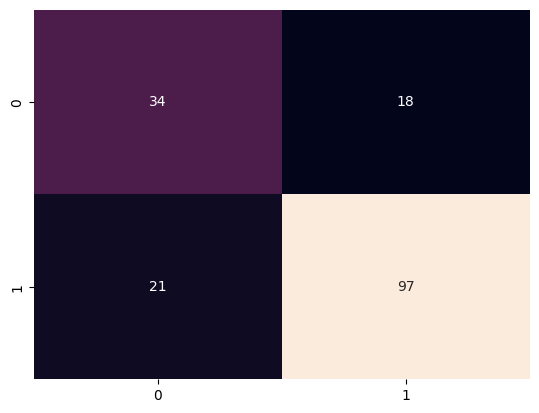

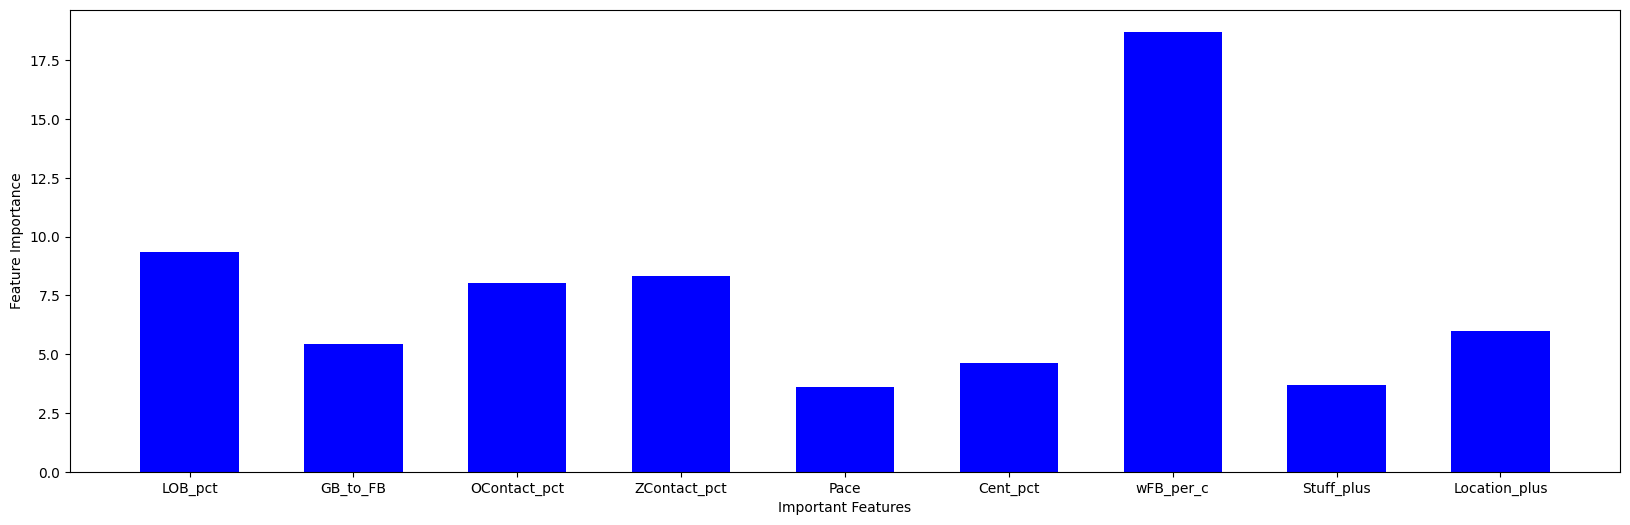

In [686]:
DTC(X, y, "gini") #criterion{gini, entropy, log_loss} #77% accuracy

              precision    recall  f1-score   support

        good       0.81      0.67      0.74        52
    not good       0.87      0.93      0.90       118

    accuracy                           0.85       170
   macro avg       0.84      0.80      0.82       170
weighted avg       0.85      0.85      0.85       170

Most important features:
LOB_pct - 4.2%
LOB_pct_plus - 3.7%
Barrel_pct - 3.8%
wFB_per_c - 6.7%
botOvr - 3.0%
Stuff_plus - 3.7%
Pitching_plus - 4.8%


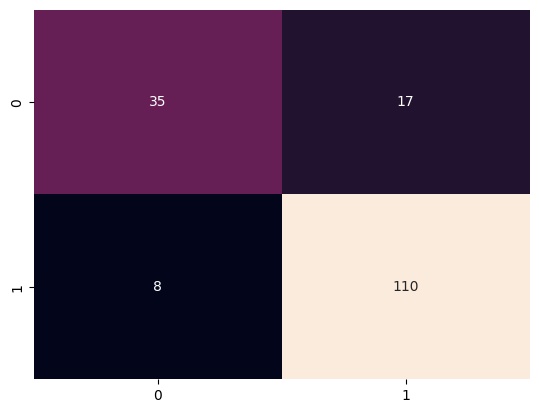

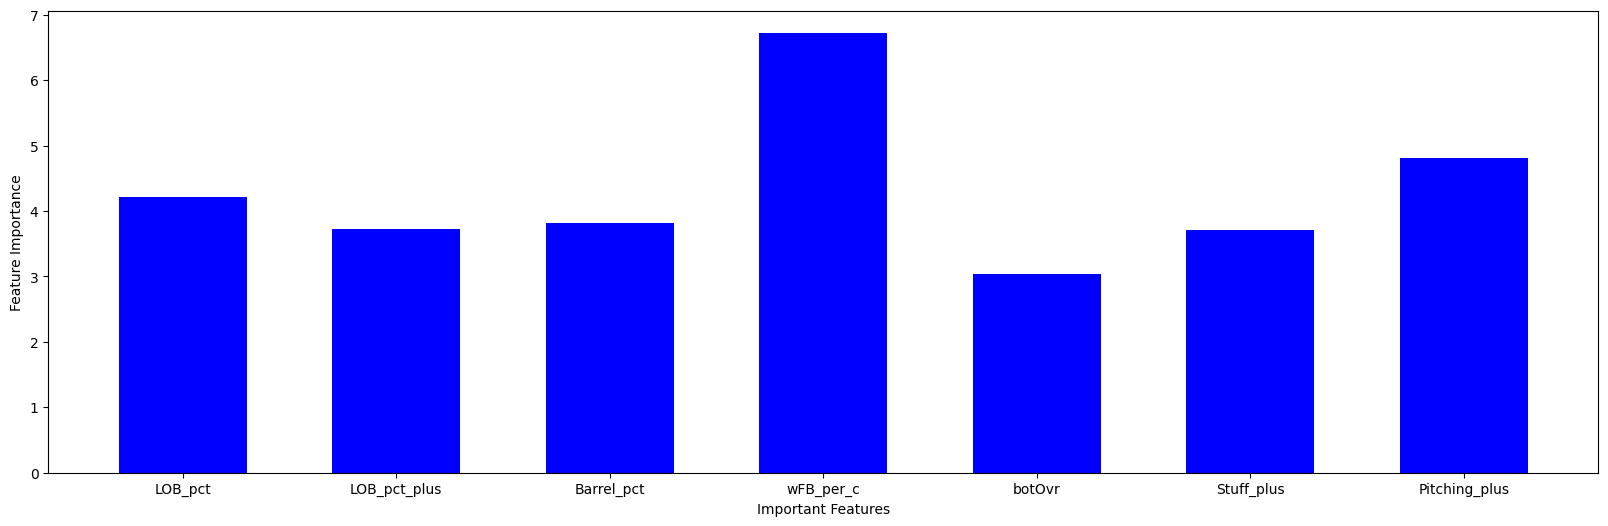

In [687]:
RFC(X, y, 20) #85% accuracy

In [688]:
#Get relievers that could be good candidates based on age, pitching plus, and barrel% to switch to a starter:
df_RP2 = df_RP[df_RP["Season"]== 2023]
df_RP2 = df_RP2[df_RP2["G"]>=30]
df_RP2 = df_RP2[df_RP2["Age"]<33]
df_RP2.sort_values("Barrel_pct", inplace = True)
df_change_candidates = df_RP2.head(20)
df_change_candidates.sort_values("Pitching_plus", inplace = True)
df_change_candidates = df_change_candidates.tail(10)

<ipython-input-688-0a8738a77164>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change_candidates.sort_values("Pitching_plus", inplace = True)


In [689]:
df_change_candidates

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,Contact_pct_sc,Zone_pct_sc,botERA,botOvr,botStf,botCmd,botxRV100,Stuff_plus,Location_plus,Pitching_plus
2011,17432,656546,Jeff Hoffman,Jeff Hoffman,R,2023,30,PHI,RP,54,...,0.6861,0.4839,4.178510,53.673879,67.168130,44.453236,-0.101235,128.334908,95.818203,102.672581
2169,25679,687330,Kevin Kelly,Kevin Kelly,R,2023,25,TBR,RP,57,...,0.7945,0.5647,3.231668,63.853621,62.919877,54.045316,-0.732463,97.404789,99.537089,104.134460
2040,17998,664126,Pete Fairbanks,Pete Fairbanks,R,2023,29,TBR,RP,49,...,0.7193,0.5490,3.009808,66.238895,67.552506,56.554052,-0.880370,131.918529,100.106948,105.435422
1955,15145,623437,Justin Topa,Justin Topa,R,2023,32,SEA,RP,75,...,0.8174,0.5889,3.013424,66.200011,56.355455,62.735473,-0.877959,101.383174,105.199044,105.573709
2147,21894,666619,Gregory Santos,Gregory Santos,R,2023,23,CHW,RP,60,...,0.7253,0.5461,2.934995,67.043221,63.340908,59.003768,-0.930245,127.223467,103.638123,107.065421
1876,12857,542888,Shawn Armstrong,Shawn Armstrong,R,2023,32,TBR,RP,33,...,0.7530,0.5693,3.244944,63.710869,50.696267,60.241073,-0.723612,104.244771,108.995098,108.596242
2015,17586,656945,Tanner Scott,Tanner Scott,L,2023,28,MIA,RP,74,...,0.6580,0.5364,2.724765,69.303442,73.048845,59.803282,-1.070398,123.753687,100.713256,111.175476
1966,15541,643511,Tyler Rogers,Tyler Rogers,R,2023,32,SFG,RP,68,...,0.7909,0.5730,3.137634,64.864599,57.522824,49.594848,-0.795153,126.159530,98.811563,111.987443
2116,20253,643377,Griffin Jax,Griffin Jax,R,2023,28,MIN,RP,71,...,0.7595,0.5492,2.492242,71.803364,69.052849,65.136532,-1.225414,128.761281,105.833652,113.263193
2045,18138,664854,Ryan Helsley,Ryan Helsley,R,2023,28,STL,RP,33,...,0.6766,0.4909,2.813789,68.346339,74.591357,52.713941,-1.011049,155.064909,100.702801,114.138715


In this role, he would have been ['not good' 'not good' 'not good' 'not good' 'not good' 'not good' 'good'
 'good' 'not good' 'not good']

              precision    recall  f1-score   support

        good       0.76      0.75      0.76        52
    not good       0.89      0.90      0.89       118

    accuracy                           0.85       170
   macro avg       0.83      0.82      0.83       170
weighted avg       0.85      0.85      0.85       170

Most important features:
LOB_pct - 4.0%
GB_to_FB - 4.0%
IFH_pct - 6.0%
SwStr_pct - 4.0%
CStr_pct - 4.0%
FRM - 4.0%
EV - 4.0%
LA - 4.0%
Barrel_pct - 8.0%
maxEV - 6.0%
wFB_per_c - 6.0%
Stuff_plus - 4.0%
Pitching_plus - 8.0%


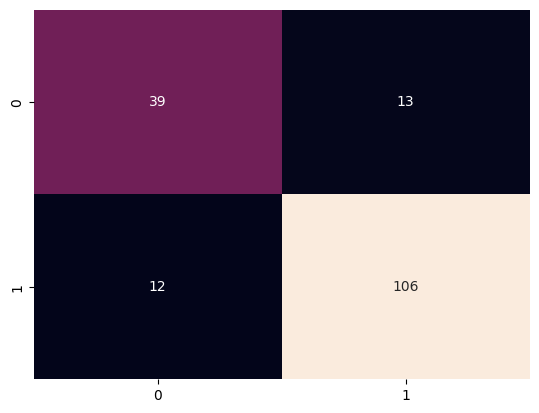

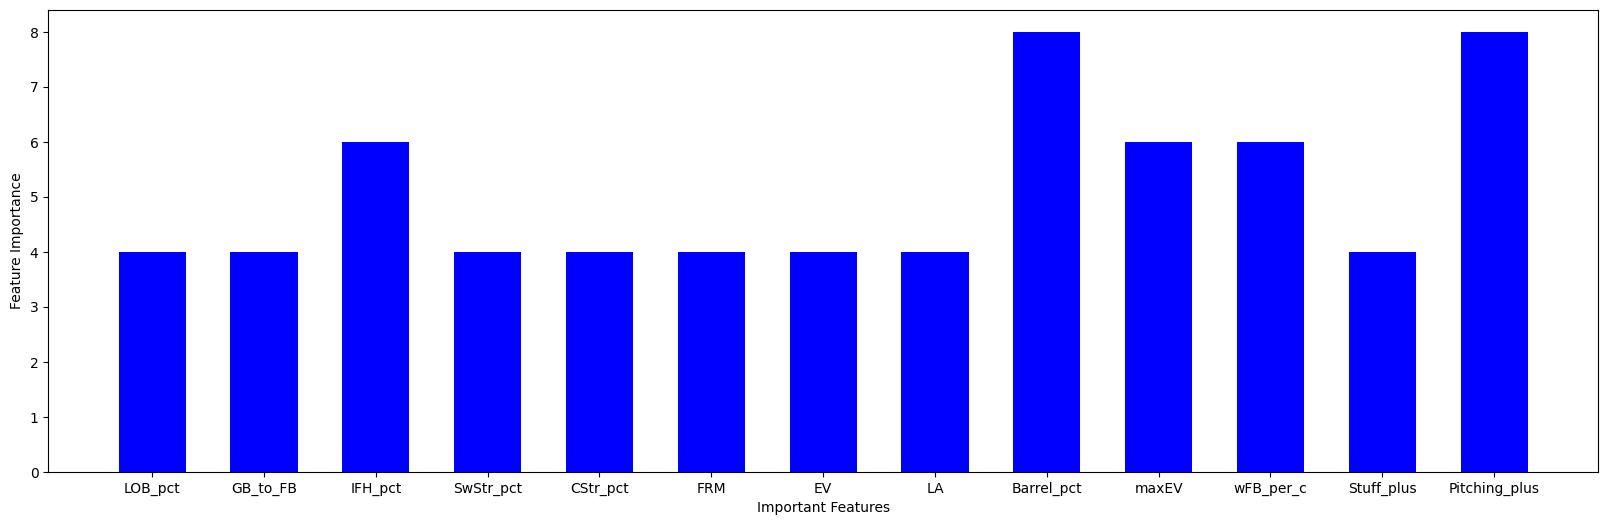

In [690]:
df_change_candidates2 = df_change_candidates.drop(df_change_candidates.iloc[:, 0:5], axis = 1)
df_change_candidates2 = df_change_candidates2.drop(df_change_candidates2.iloc[:, 2:4], axis = 1)
df_change_candidates2.drop(["Strikes", "Balls", "SO", "Dollars", "G", "Pitches", "IP", "TBF",
                   "R", 'ER', 'ERA', 'Events', "FIP", "Pulls", 'tERA', "RAR",
                   "WPA_to_LI", 'RE24', "REW", "WPA", "inLI", "pLI", "gmLI", "RA9_WAR",
                   'FIP_minus', "xFIP_minus", "ERA_minus", "SIERA", "K_minus_BB_pct",
                   "xFIP", "kwERA", "HR_per_9", "K_pct_plus", 'HR_per_9_plus', "WHIP", "BB_pct",
                   "K_pct", "BB_pct_plus", 'K_per_9', "HR_to_FB", "WHIP_plus", "BB",
                   'K_to_BB', "K_per_9_plus", "HR_to_FB_pct_plus", 'HR',
                   "H_per_9", "H_per_9_plus", "LD", "LD_pct", 'H', 'W', "L", "LOB_Wins",
                   'BB_per_9', "AVG_plus", 'BABIP_plus', "BIP_Wins", 'FDP_Wins', 'HardHit',
                   "BABIP", "AVG", 'E_minus_F', "BB_per_9_plus", "IFFB", "Clutch", "GS", "CSW_pct",
                   "RS", "IFH", "GB", "FB", "Barrels", "BUH", "BU", "WP", 'HBP', "IFFB_pct",
                   "wFB", "WAR", "TTO_pct"], axis = 1, inplace = True)

df_change = pd.DataFrame(scaler.fit_transform(df_change_candidates2), columns = df_change_candidates2.columns)
ADA(X, y, 50, 1, df_change, "SAMME.R")#algorithm="SAMME.R" or "SAMME", learning_rate = 1; #85% accuracy

In this role, he would have been ['not good' 'not good' 'good' 'not good' 'not good' 'not good' 'not good']

              precision    recall  f1-score   support

        good       0.76      0.75      0.76        52
    not good       0.89      0.90      0.89       118

    accuracy                           0.85       170
   macro avg       0.83      0.82      0.83       170
weighted avg       0.85      0.85      0.85       170

Most important features:
LOB_pct - 4.0%
GB_to_FB - 4.0%
IFH_pct - 6.0%
SwStr_pct - 4.0%
CStr_pct - 4.0%
FRM - 4.0%
EV - 4.0%
LA - 4.0%
Barrel_pct - 8.0%
maxEV - 6.0%
wFB_per_c - 6.0%
Stuff_plus - 4.0%
Pitching_plus - 8.0%


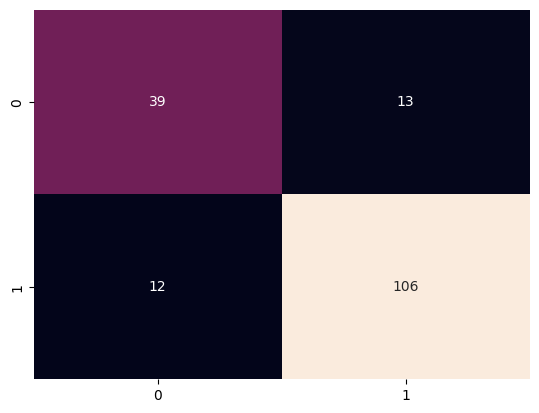

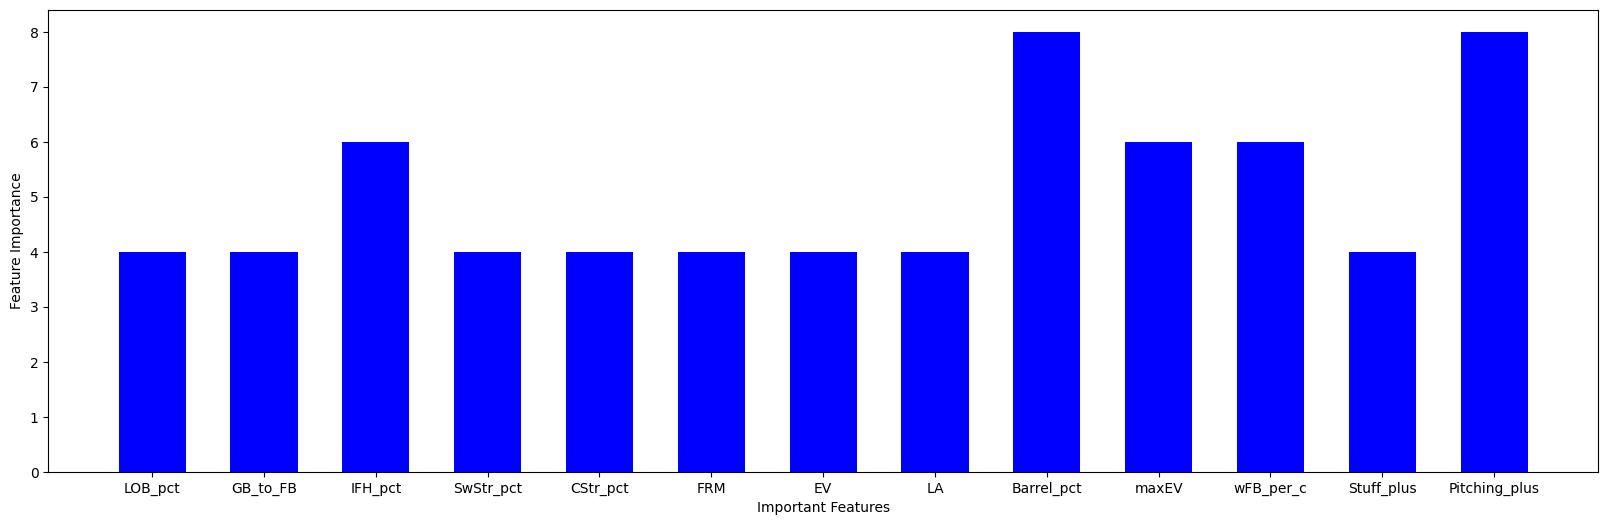

In [691]:
#Get Reds relievers that could be good candidates based on age, pitching plus, and barrel% to switch to a starter and send to model:
df_Reds_candidates = df_RP2[df_RP2["Team"]=="CIN"]
df_change_candidates2 = df_Reds_candidates.drop(df_Reds_candidates.iloc[:, 0:5], axis = 1)
df_change_candidates2 = df_change_candidates2.drop(df_change_candidates2.iloc[:, 2:4], axis = 1)
df_change_candidates2.drop(["Strikes", "Balls", "SO", "Dollars", "G", "Pitches", "IP", "TBF",
                   "R", 'ER', 'ERA', 'Events', "FIP", "Pulls", 'tERA', "RAR",
                   "WPA_to_LI", 'RE24', "REW", "WPA", "inLI", "pLI", "gmLI", "RA9_WAR",
                   'FIP_minus', "xFIP_minus", "ERA_minus", "SIERA", "K_minus_BB_pct",
                   "xFIP", "kwERA", "HR_per_9", "K_pct_plus", 'HR_per_9_plus', "WHIP", "BB_pct",
                   "K_pct", "BB_pct_plus", 'K_per_9', "HR_to_FB", "WHIP_plus", "BB",
                   'K_to_BB', "K_per_9_plus", "HR_to_FB_pct_plus", 'HR',
                   "H_per_9", "H_per_9_plus", "LD", "LD_pct", 'H', 'W', "L", "LOB_Wins",
                   'BB_per_9', "AVG_plus", 'BABIP_plus', "BIP_Wins", 'FDP_Wins', 'HardHit',
                   "BABIP", "AVG", 'E_minus_F', "BB_per_9_plus", "IFFB", "Clutch", "GS", "CSW_pct",
                   "RS", "IFH", "GB", "FB", "Barrels", "BUH", "BU", "WP", 'HBP', "IFFB_pct",
                   "wFB", "WAR", "TTO_pct"], axis = 1, inplace = True)

df_change = pd.DataFrame(scaler.fit_transform(df_change_candidates2), columns = df_change_candidates2.columns)
ADA(X, y, 50, 1, df_change, "SAMME.R")

In [692]:
df_Reds_candidates

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,Contact_pct_sc,Zone_pct_sc,botERA,botOvr,botStf,botCmd,botxRV100,Stuff_plus,Location_plus,Pitching_plus
858,17480,650960,Daniel Duarte,Daniel Duarte,R,2023,26,CIN,RP,31,...,0.7839,0.5262,4.560684,49.565022,49.016569,51.454377,0.153548,105.395463,98.487477,99.225771
391,13133,571882,Derek Law,Derek Law,R,2023,32,CIN,RP,51,...,0.7617,0.4894,5.140391,43.332453,43.897169,39.935174,0.540019,100.522396,100.253527,97.355767
2035,17871,664139,Ian Gibaut,Ian Gibaut,R,2023,29,CIN,RP,74,...,0.7584,0.5461,3.313083,62.978313,53.717081,64.604926,-0.678187,106.004610,105.949707,106.779715
963,18333,622065,Alex Young,Alex Young,L,2023,29,CIN,RP,63,...,0.7039,0.4760,4.581530,49.340923,42.530167,51.142899,0.167445,82.731908,101.111792,95.722543
2136,21132,664747,Alexis DÃ­az,Alexis Diaz,R,2023,26,CIN,RP,71,...,0.6796,0.4617,5.099308,43.774155,71.412799,36.847829,0.512630,94.199390,89.600697,96.348693
1939,14814,571656,Buck Farmer,Buck Farmer,R,2023,32,CIN,RP,71,...,0.7125,0.4853,4.726271,47.784774,47.430303,50.052664,0.263939,97.347545,99.204010,98.336743
1897,13470,608371,Lucas Sims,Lucas Sims,R,2023,29,CIN,RP,67,...,0.6889,0.4849,4.021927,55.357354,60.586953,45.908858,-0.205624,131.208126,95.334130,104.102294


In [693]:
df_Reds_candidates["Barrel_pct"]

858     0.0435
391     0.0516
2035    0.0599
963     0.0606
2136    0.0649
1939    0.0874
1897    0.0876
Name: Barrel_pct, dtype: float64

In [694]:
df_Reds_candidates["wFB_per_c"]

858    -0.372608
391    -0.346294
2035    1.314869
963    -1.193189
2136   -0.329245
1939   -0.400021
1897    0.090848
Name: wFB_per_c, dtype: float64

In [695]:
df_Reds_candidates["maxEV"]

858     110.550
391     110.590
2035    109.232
963     112.427
2136    109.088
1939    111.663
1897    109.663
Name: maxEV, dtype: float64

**RP**

In [696]:
#Scale data:
scaler = StandardScaler()
df_inputs_scaled = pd.DataFrame(scaler.fit_transform(df_inputs_RP), columns = df_inputs_RP.columns)

#Set inputs/target:
X = df_inputs_scaled
y = df_RP["WAR"]

**Classify if player was a good or a bad starter:**

              precision    recall  f1-score   support

        good       0.65      0.62      0.63       130
    not good       0.79      0.81      0.80       230

    accuracy                           0.74       360
   macro avg       0.72      0.71      0.72       360
weighted avg       0.74      0.74      0.74       360

Most important features:
Contact_pct - 7.5%
SwStr_pct - 3.2%
FRM - 3.1%
LD_pct_plus - 3.9%
Barrel_pct - 9.2%
wFB_per_c - 3.9%
botOvr - 18.0%
Pitching_plus - 3.6%


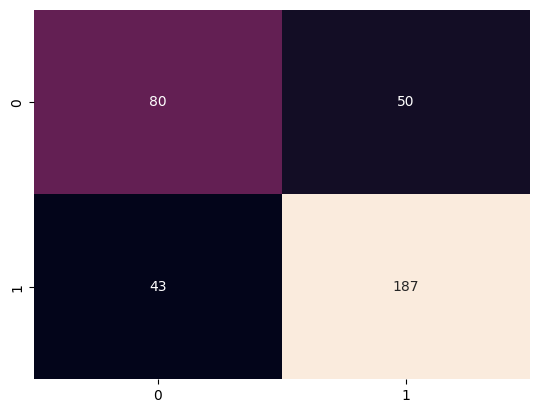

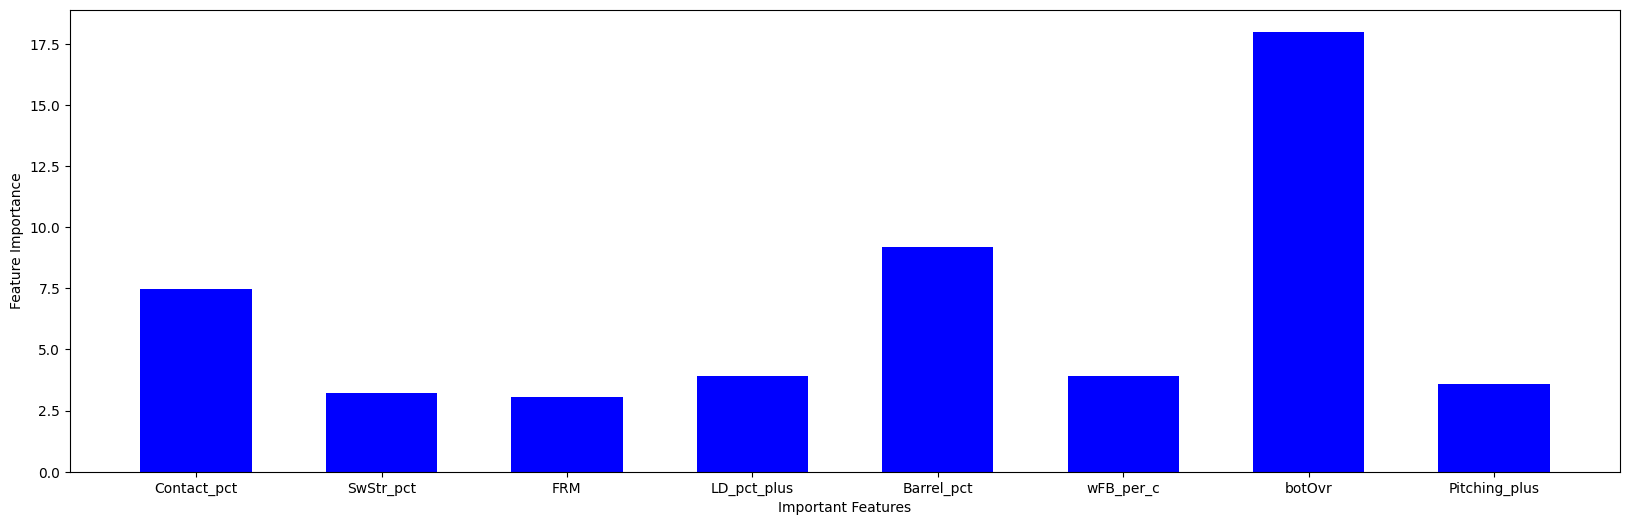

In [697]:
DTC(X, y, "gini") #criterion{“gini, "entropy”, “log_loss”} #74% accuracy

              precision    recall  f1-score   support

        good       0.80      0.50      0.62       130
    not good       0.77      0.93      0.84       230

    accuracy                           0.78       360
   macro avg       0.78      0.72      0.73       360
weighted avg       0.78      0.78      0.76       360

Most important features:
Contact_pct - 3.5%
SwStr_pct - 4.6%
Barrel_pct - 3.7%
wFB_per_c - 6.8%
Contact_pct_sc - 3.1%
botERA - 6.6%
botOvr - 7.9%
botStf - 3.4%
botxRV100 - 6.6%
Stuff_plus - 6.7%
Pitching_plus - 6.9%


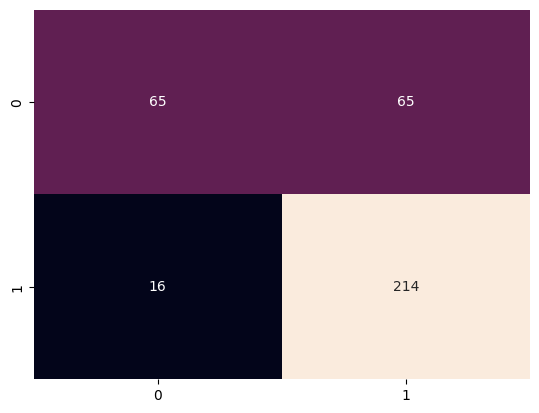

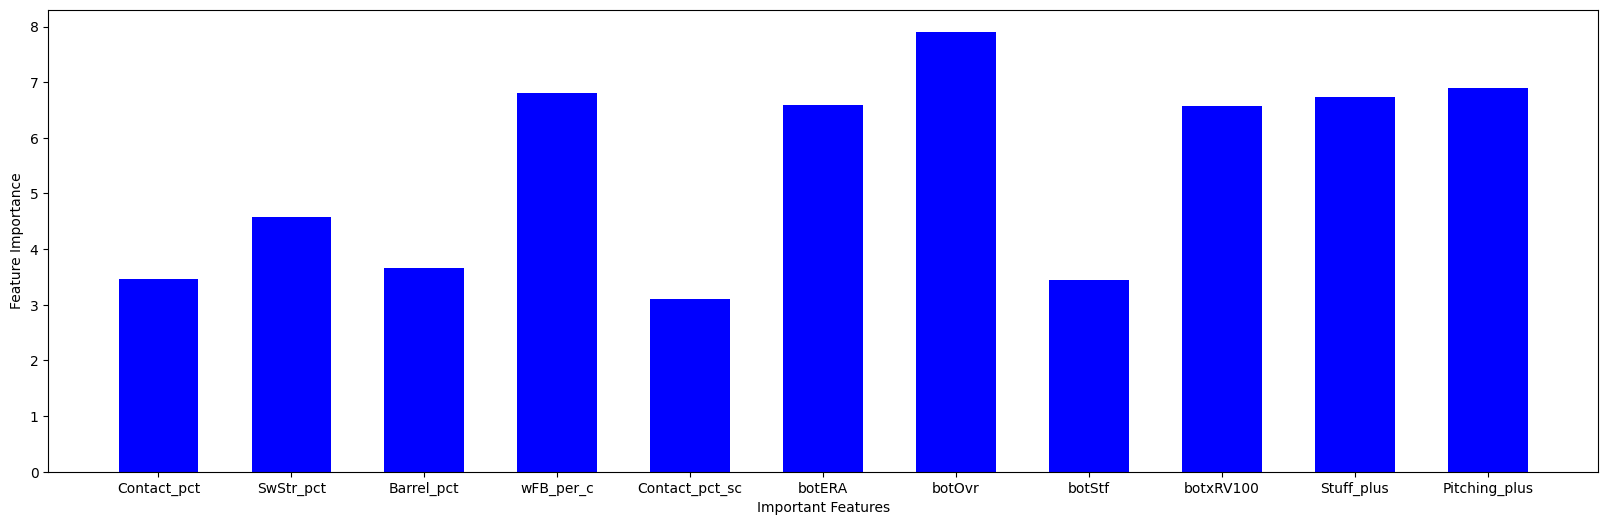

In [698]:
RFC(X, y, 4) #78% accuracy

In [699]:
predict_df = df_inputs_scaled.iloc[0, :]
predict_df = pd.DataFrame(predict_df)
predict_df = predict_df.transpose()

In this role, he would have been ['not good']

              precision    recall  f1-score   support

        good       0.77      0.62      0.68       130
    not good       0.80      0.90      0.85       230

    accuracy                           0.79       360
   macro avg       0.79      0.76      0.77       360
weighted avg       0.79      0.79      0.79       360

Most important features:
WP - 3.3%
RS_per_9 - 6.7%
LOB_pct - 3.3%
OSwing_pct - 3.3%
SwStr_pct - 5.0%
CStr_pct - 3.3%
FRM - 5.0%
LD_pct_plus - 3.3%
Pull_pct_plus - 3.3%
Barrel_pct - 11.7%
maxEV - 3.3%
wFB_per_c - 10.0%
Contact_pct_sc - 10.0%
Pitching_plus - 6.7%


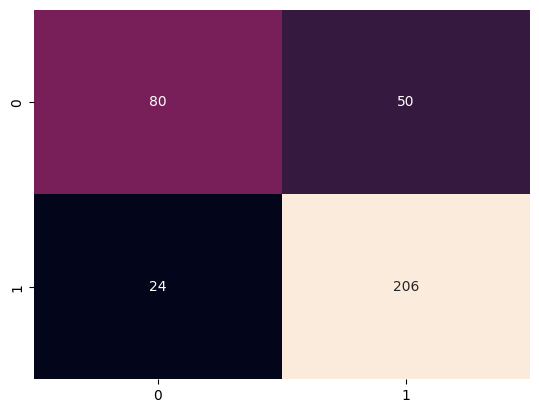

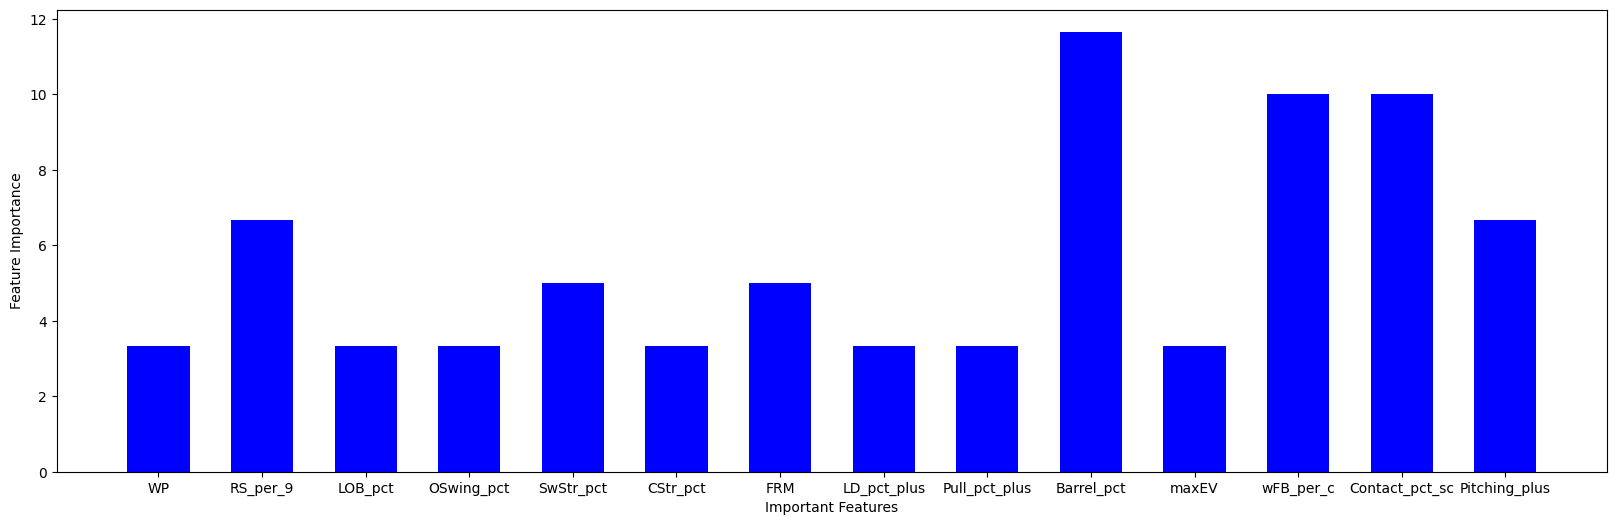

In [700]:
ADA(X, y, 60, .2, predict_df, "SAMME.R") #algorithm="SAMME.R" or "SAMME", learning_rate = 1; 77% accuracy